In [2]:
import numpy as np
import matplotlib.pyplot as plt
from latexify import latexify
import os

from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

from scipy.optimize import minimize
from scipy import optimize

import sympy as sp
%matplotlib widget

# Define functions

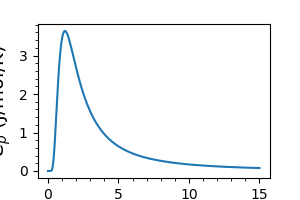

In [6]:
# Function for calculate and plot crystal field/nuclear Zeeman heat capacity
kb = 1.38*10**-23
nmol = 6*10**23
R = 8.31
t = sp.symbols('t')

def cefcp(t, elevels, degen):  
    # this fun retures a sympy object containing symbol 't'
    e = elevels*11.606*kb; g = degen
    energy = nmol*sum([ei*gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])/sum([gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])
    cp = sp.diff(energy,t)# sp.Sum can not sum over a python list, but sum can and sp.diff works on the summation
    return cp

def cefcp2(t, elevels, degen):  
    e, g = elevels*11.606*kb, degen
    energy_av = nmol*sum([ei*gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])/sum([gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])
    energy2_av = nmol*sum([ei**2*gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])/sum([gi*sp.exp(-ei/kb/t) for ei,gi in zip(e, g)])
    cp = (-energy2_av + energy_av**2)**0.5/t**2
    return cp

def lamcefcp(elevels, degen):
    # return a fun that take the temperature as varable which can be array
    cefcpv = sp.lambdify(t, cefcp(t, elevels, degen), modules=['numpy', 'sympy'])
    return cefcpv

def npcefcp(tRange, npts, elevels, degen):     
    temps = np.linspace(tRange[0],tRange[1],num=npts,endpoint=True)
    cefcpv = lamcefcp(elevels, degen)  
    cefcpdat = cefcpv(temps)
    return temps, cefcpdat

def plotcefcp(tRange, npts, elevels, degen):     
    x, y = npcefcp(tRange, npts, elevels, degen)
    fig, ax = plt.subplots(figsize=(3,2))
    plt.plot(x,y)
    plt.minorticks_on()
    plt.xlabel(r"T (K)",size=14)
    plt.ylabel(r'$C_p$ (J/mol/K)',size=14)
    #fig.show()
    return x, y

def fitReg(dat, *args):
    if len(args)==1:# when the low and high limits is in a list
        mask = (args[0][0]< dat[:,0]) & (dat[:,0] < args[0][1])
    else: # two augs give the the two limits
        mask = (args[0]< dat[:,0]) & (dat[:,0] < args[1])
    return dat[mask,:]

def t3_law(t,a):
    return a * t**3

# Ho2GaSbO7 nuclear Zeeman specific heat
elevels = np.arange(0,8)*0.2/11.6 # nuclear spin I=7/2, 8 equidistant energy levels with overall splitting 7x0.3K
degen = np.ones(8)
elevels = np.arange(0,2)*0.25 # two level system with a 0.25meV gap
degen = np.ones(2)
ts, Cp_nuclearHo = plotcefcp([0.01,15.0], 1000, elevels, degen)
nucCp_interp1d = interp1d(ts, Cp_nuclearHo)

# ts = np.linspace(0.01, 15.0, num=100)
# cps = [cefcp2(t,elevels, degen) for t in ts]
# plt.gca().plot(ts, cps)



In [7]:
0.25*11.6

2.9

# Spicific heat data of Ho2GaSbO7

## Ho2GaSbO7 Cp 1969 with Ho2Ti2O7 (Export figure)

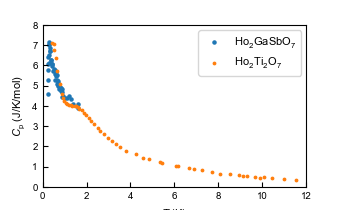

In [4]:
path = r'D:\4_Physical_Properties\Ho2GaSbO7'
Cp_hogasbo = np.genfromtxt(os.path.join(path,'cp_1969.txt'),delimiter=',')
Cp_hotio = np.genfromtxt(os.path.join(path,'Cp_HoTiO.txt'),delimiter=',')
from latexify import latexify
latexify()
fig, ax = plt.subplots()
ax.scatter(Cp_hogasbo[:,0], Cp_hogasbo[:,1]*8.13,s=5, label=r'Ho$_2$GaSbO$_7$')
ax.scatter(Cp_hotio[:,0], Cp_hotio[:,1], s=3, label=r'Ho$_2$Ti$_2$O$_7$')
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$C_\mathrm{p}$ (J/K/mol)')
ax.set_xlim([0,12])
ax.set_ylim([0,8])
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xlim([0.1,2])
#ax.set_ylim([0.1,2.0])
ax.legend(loc='best')
plt.show()

In [4]:
fig.savefig(r'D:/Downloads/Cp.png', bbox_inches="tight",pad_inches=0.02)

## Measured high T data of a powder sample (Hao Deng)

[0.00040626]


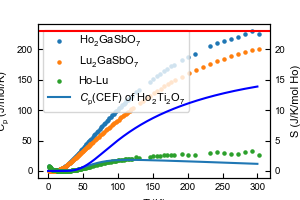

In [5]:
#Cp_hogasbo_HT = np.genfromtxt(os.path.join(path,'sample-220530-1-out.dat'),delimiter=',', skip_header=1)
Cp_hogasbo_HT = np.genfromtxt(os.path.join(path,'Cp_powder_220530-1\Ho2GaSbO7_Lu2GaSbO7.txt'), skip_header=1)
Lu_interp1d = interp1d(Cp_hogasbo_HT[:,3], Cp_hogasbo_HT[:,4])
Ho_m_Lu = Cp_hogasbo_HT[:,1] - Lu_interp1d(Cp_hogasbo_HT[:,0])

temp = fitReg(Cp_hogasbo_HT,30,40)
popt, pcov = optimize.curve_fit(t3_law, temp[:,0], temp[:,1], [0.0005])
print(popt)

fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(Cp_hogasbo_HT[:,0],Cp_hogasbo_HT[:,1], s=5, label=r'Ho$_2$GaSbO$_7$')
ax.scatter(Cp_hogasbo_HT[:,3],Cp_hogasbo_HT[:,4], s=5, label=r'Lu$_2$GaSbO$_7$')
ax.scatter(Cp_hogasbo_HT[:,0], Ho_m_Lu, s=5, label='Ho-Lu')
#ax.plot(temp[:,0], t3_law(temp[:,0], popt[0]),c='r', label='$\sim T^3$')

elevels = np.array([0,21,22,27,28,59,69,70,71,76,81]) #CF lever of Ho2Ti2O7 from Figure 1 of S. Rosenkranz et al, Journal Of Applied Physics 87, 5914 (2000).
degen   = np.array([2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1])
x, y = npcefcp([0.01,300], 1000, elevels, degen)
ax.plot(x,2*y,label=r'$C_\mathrm{p}$(CEF) of Ho$_2$Ti$_2$O$_7$')

ax.set_xlabel('$T$ (K)')
ax.set_ylabel(r'$C_\mathrm{p}$ (J/mol/K)')
ax.legend()


ax1 = ax.twinx()
entropy_calc = cumtrapz(y/x, x,initial=0.0)
ax1.plot(x, entropy_calc,c='blue')
ax1.axhline(y=8.13*np.log(17),c='r',label='Rln17')
ax1.set_ylabel('S (J/K/mol Ho)')
plt.show()

In [6]:
fig.savefig(os.path.join(path,'cef_Ho2GaSbO7.pdf'), bbox_inches="tight", pad_inches=0.01)

## Combined

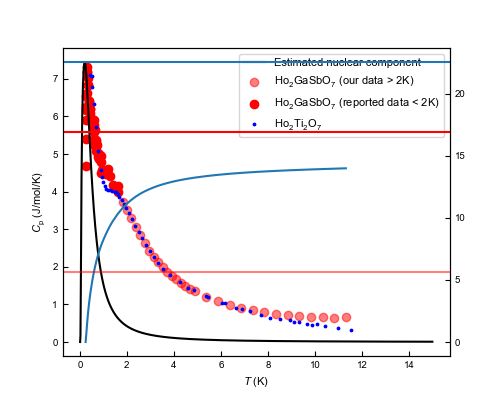

In [6]:
#latexify()
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(ts, Cp_nuclearHo,c='black', label='Estimated nuclear component')
ax.scatter(Cp_hogasbo_HT[:30,0],Cp_hogasbo_HT[:30,1]/2, c='red', alpha=0.5, label='Ho$_2$GaSbO$_7$ (our data > 2K)')
#ax.scatter(Cp_hogasbo_HT[:30,0],Cp_hogasbo_HT[:30,1]/2-0.0004*Cp_hogasbo_HT[:30,0]**3, c='red', alpha=0.5, label='Ho$_2$GaSbO$_7$ (our data-$aT^3$)')
ax.scatter(Cp_hogasbo[:,0],Cp_hogasbo[:,1]*8.3,c='red', label='Ho$_2$GaSbO$_7$ (reported data < 2K)')
ax.scatter(Cp_hotio[:,0],Cp_hotio[:,1], c='blue',label='Ho$_2$Ti$_2$O$_7$', s=3)

ax1 = ax.twinx()
Cp_hogasbo = Cp_hogasbo[np.argsort(Cp_hogasbo[:,0]),:]
all_t = np.hstack([Cp_hogasbo[:,0], Cp_hogasbo_HT[:30,0]]) #Combining the two temperature ranges
Ho_Cp = np.hstack([Cp_hogasbo[:,1]*8.3, Cp_hogasbo_HT[:30,1]/2]) #Combining the two temperature ranges

nuc_Cp = nucCp_interp1d(all_t) # calc nuclear Cp for all T
el_Cp = Ho_Cp-nuc_Cp
#ax.plot(all_t, el_Cp)

entropy = cumtrapz(Ho_Cp/all_t,all_t, initial=0.0)
ax1.plot(all_t, entropy)
ax1.axhline(y=8.13*(np.log(2)+np.log(8)))
ax1.axhline(y=8.13*np.log(2),c='r',alpha=0.5)
ax1.axhline(y=8.13*np.log(8),c='r')

ax.set_xlabel('$T$ (K)')
ax.set_ylabel(r'$C_\mathrm{p}$ (J/mol/K)')
ax.legend()
plt.show()

In [8]:
plt.close('all')

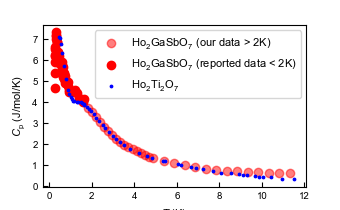

In [8]:
latexify()
fig, ax = plt.subplots()#figsize=(5,4))
ax.scatter(Cp_hogasbo_HT[:30,0],Cp_hogasbo_HT[:30,1]/2, c='red', alpha=0.5, label='Ho$_2$GaSbO$_7$ (our data > 2K)')
#ax.scatter(Cp_hogasbo_HT[:30,0],Cp_hogasbo_HT[:30,1]/2-0.0004*Cp_hogasbo_HT[:30,0]**3, c='red', alpha=0.5, label='Ho$_2$GaSbO$_7$ (our data-$aT^3$)')
ax.scatter(Cp_hogasbo[:,0],Cp_hogasbo[:,1]*8.3,c='red', label='Ho$_2$GaSbO$_7$ (reported data < 2K)')
ax.scatter(Cp_hotio[:,0],Cp_hotio[:,1], c='blue',label='Ho$_2$Ti$_2$O$_7$', s=3)

ax.set_xlabel('$T$ (K)')
ax.set_ylabel(r'$C_\mathrm{p}$ (J/mol/K)')
ax.legend()
plt.show()

In [9]:
fig.savefig(os.path.join(path,'lowT_Cp_Ho2GaSbO7.pdf'), bbox_inches="tight", pad_inches=0.01)